In [ ]:

# connecting to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#changing to current working directory
import os

project_folder = "drive//MyDrive//creditCardDefaultClassification"
os.chdir(project_folder)

os.getcwd()

'/content/drive/MyDrive/creditCardDefaultClassification'

In [1]:
#Installing catboost and xgboost
!pip install catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00


In [4]:
# importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm  import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
import sklearn
import catboost
import xgboost
print(sklearn.__version__)
print(catboost.__version__)

print(xgboost.__version__)

1.2.2
1.2.2
2.0.1


In [ ]:
from jupyterNotebook import model_params

In [ ]:
# Loading dataset in which processed and balanced
dataset = pd.read_csv(".//dataFiles//preprocessed_dataset.csv")

dataset.head()

,default.payment.next.month,LIMIT_BAL,AGE,PAY_SEPT,PAY_AUG,PAY_JULY,PAY_JUNE,PAY_MAY,PAY_APRIL,BILL_AMT_SEPT,BILL_AMT_JUNE,BILL_AMT_MAY,BILL_AMT_APRIL,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JULY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL
0,1,0.019608,24,2,2,-1,-1,-2,-2,0.108224,0.329258,0.333178,0.320342,0.000000,0.061250,0.000000,0.000000,0.000000,0.000000
1,1,0.215686,26,-1,2,0,0,0,2,0.101293,0.345789,0.351934,0.338650,0.000000,0.088897,0.093694,0.104341,0.000000,0.203728
2,0,0.156863,34,0,0,0,0,0,0,0.250822,0.401665,0.414328,0.407636,0.137837,0.133345,0.093694,0.104341,0.103093,0.509321
3,0,0.078431,37,0,0,0,0,0,0,0.350769,0.472315,0.490391,0.486223,0.181604,0.179483,0.112433,0.114775,0.110206,0.101864
4,0,0.078431,57,-1,0,-1,0,0,0,0.134710,0.435057,0.437118,0.427746,0.181604,0.199796,0.936944,0.939065,0.071031,0.069166


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46728 entries, 0 to 46727
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   default.payment.next.month  46728 non-null  int64  
 1   LIMIT_BAL                   46728 non-null  float64
 2   AGE                         46728 non-null  int64  
 3   PAY_SEPT                    46728 non-null  int64  
 4   PAY_AUG                     46728 non-null  int64  
 5   PAY_JULY                    46728 non-null  int64  
 6   PAY_JUNE                    46728 non-null  int64  
 7   PAY_MAY                     46728 non-null  int64  
 8   PAY_APRIL                   46728 non-null  int64  
 9   BILL_AMT_SEPT               46728 non-null  float64
 10  BILL_AMT_JUNE               46728 non-null  float64
 11  BILL_AMT_MAY                46728 non-null  float64
 12  BILL_AMT_APRIL              46728 non-null  float64
 13  PAY_AMT_SEPT                467

**Train test split**

Using sklearn train-test-split function we split train and test in the ration 80:20.

In [ ]:
target = 'default.payment.next.month'

dataset_X = dataset.drop(target, axis=1)
dataset_y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(
                                                    dataset_X,
                                                    dataset_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

<h1>Model Building</h1>

In this section we will `KNN, LOGISTIC REGRESSION and CART(classification and Regression Trees) ALGORITHMS`. As these algorithms and along with hyperparameters details are in `model_params.py` file saved in current folder.
In that file we have model_params dictionary which has model initialization along hyperparams need to tune. Here we will load dictionary.

In [ ]:
dict_models  = model_params.models_params
dict_models

In [ ]:
def train_ml_classification_models(training_models,X_train, y_train,
                                   X_test,y_test):
    """
    This function helps to train the model and stores the result
    """
    scores = []
    feature_importance = {}
    for model_name, model_info in training_models.items():
        model = model_info['model_ini']
        model.fit(X_train, y_train)
        validation_mean = np.mean(cross_val_score(model,X_train,
                                                  y_train,cv=5))

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        y_train_prob = model.predict_proba(X_train)[::,1]
        y_test_prob = model.predict_proba(X_test)[::,1]

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        auc_roc_score = roc_auc_score(y_test, y_pred_test)

        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,
                                                           y_train_prob)
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)

        scores.append({'model':model_name,
                       'train_accuracy':train_accuracy,
                       'test_accuracy':test_accuracy,
                       'auc_roc_score':auc_roc_score,
                       'fpr_train':fpr_train,
                       'tpr_train':tpr_train,
                       'fpr_test':fpr_test,
                       'tpr_test':tpr_test})


        if model_name in ['Random_forest','gradient_boost','xgb','catboost']:
            feature_importance[model_name] = model.feature_importances_
        print('{} training completed'.format(model_name))

    scores_data = pd.DataFrame(scores, columns = ['model','train_accuracy',
                                                  'test_accuracy','auc_roc_score',
                                                  'fpr_train','tpr_train',
                                                  'fpr_test','tpr_test'])
    feature_impo_df = pd.DataFrame(feature_importance,
                                   columns = feature_importance.keys(),
                                   index =X_train.columns)
    feature_impo_df.to_csv('.//dataFiles//feature_importance.csv', index=True)

    return scores_data



In [ ]:
scores_data = train_ml_classification_models(dict_models,X_train,y_train,
                               X_test,y_test)
scores_data.loc[:,['model','train_accuracy','test_accuracy','auc_roc_score']]

From above we can see that `Decision Tree, Random Forest` model are overfitting if you compare train and test accuracy. And from `XGB and Catboost` the difference between train and test accuracy will be `6-8%` slightly overfitting which we will fine tune the hyperparameters.

In [ ]:
def plot_auc_plot(dict_models):
    """
    This functions helps to plot relationhip between two bariables
    """
    fig, axes = plt.subplots(3,3, figsize=(15,15))

    row_value = -1
    column_value = 1
    for i, model_info in dict_models.iterrows():
        plt.subplot(3, 2, column_value)

        model_name = model_info['model']
        auc_roc = model_info['auc_roc_score']
        title  = "{} and roc score is {:.2f}".format(model_name,
                                                     model_info['auc_roc_score']
                                                     )


        plt.plot(model_info['fpr_train'], model_info['tpr_train'])
        plt.plot(model_info['fpr_test'], model_info['tpr_test'])
        plt.title(title)
        plt.legend(['train','test'])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        column_value += 1


plot_auc_plot(scores_data)

From the above graph we can seee that `KNearestNeighbour, DecisionTree, Randomforest, GradientBoosting, XGB and Catboost` having good aucroc score. Here we will try to tune the these models..

In [ ]:
dict_models

In [ ]:
%%time
hyperparaeameters_scores = []
for model_name, model_params in dict_models.items():
        model = RandomizedSearchCV(model_params['model_ini'],
                                   model_params['params'],
                                   cv = 5, return_train_score=False,
                                   refit = True)
        model.fit(X_train,y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        hyperparaeameters_scores.append({'model': model_name,
            'best_parameters': model.best_params_,
            'score': model.best_score_,
            'train_acc': accuracy_score(y_train, y_pred_train),
            'test_acc': accuracy_score(y_test, y_pred_test),
            'roc_score': roc_auc_score(y_test, y_pred_test)
        })

scores_df = pd.DataFrame(hyperparaeameters_scores, columns=['model',
                                                            'best_parameters',
                                                            'score',
                                                            'train_acc',
                                                            'test_acc',
                                                            'roc_score'])

scores_df

In [ ]:
scores_df

`XGB, Gradient Boosting Algorithm and catboost` giving good results. We will make stacking classifiers to give good results. We will use different combinations 2models for estimators and final_estimator will be one model. We will choose combination which gives higher roc_auc_score...

In [ ]:
from sklearn.ensemble import StackingClassifier

def get_results_stacking_classifier(X_train, y_train,
                                    X_test,y_test):
    list_stacking_list = []
    # Create a XGBoost classifier
    xgbboost = XGBClassifier(n_estimators=150,
                             max_depth=6,
                             learning_rate=0.05)

    # Create a gradient boosting classifier
    gradientboost = GradientBoostingClassifier(n_estimators=150,
                                               max_depth=6,
                                               learning_rate=0.05)

    # Create a catboost
    catboost = CatBoostClassifier(verbose=False,
                                  n_estimators=160,
                                  max_depth=7,
                                  allow_writing_files=False)

    estimators_list = [[('catboost',catboost),('gb', gradientboost)],
                      [('catboost',catboost),('xgb', xgbboost)],
                      [('gb', gradientboost),('xgb', xgbboost)]]

    last_estimators = [xgbboost,gradientboost,catboost]
    # Create a stacking classifier

    for i in range(len(estimators_list)):
        sclf = StackingClassifier(estimators=estimators_list[i],
                                  final_estimator=last_estimators[i],
                                  cv=10,
                                  passthrough = True)
        sclf.fit(X_train, y_train)
        y_pred = sclf.predict(X_test)
        list_stacking_list.append({'base_estimators':estimators_list[i],
                                  'final_estimators':last_estimators[i],
                                  'train_accuracy':sclf.score(X_train, y_train),
                                  'test_accuracy':sclf.score(X_test, y_test),
                                  'roc_score':roc_auc_score(y_test, y_pred)})

    stacking_details = pd.DataFrame(list_stacking_list,
                                    columns=['base_estimators',
                                              'final_estimators',
                                              'train_accuracy',
                                              'test_accuracy',
                                              'roc_score'])
    return stacking_details

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 24.3 µs


In [ ]:
%%time
stacking_details = get_results_stacking_classifier(X_train, y_train,
                                                   X_test,y_test)
stacking_details

,base_estimators,final_estimators,train_accuracy,test_accuracy,roc_score
0,"[(catboost, <catboost.core.CatBoostClassifier ...","XGBClassifier(base_score=None, booster=None, c...",0.906185,0.878344,0.878425
1,"[(catboost, <catboost.core.CatBoostClassifier ...","GradientBoostingClassifier(learning_rate=0.05,...",0.907094,0.878451,0.878528
2,"[(gb, GradientBoostingClassifier(learning_rate...",<catboost.core.CatBoostClassifier object at 0x...,0.930822,0.878772,0.878841


<u>Feature Selection</u>:

We will load feature_importance of `CART` algorithms.

In [ ]:
features_impo = pd.read_csv('.//dataFiles//feature_importance.csv')
features_impo

,Unnamed: 0,Random_forest,gradient_boost,xgb,catboost
0,LIMIT_BAL,0.088447,0.167579,0.074114,52.725147
1,AGE,0.065121,0.002271,0.014395,0.922719
2,PAY_SEPT,0.090884,0.348479,0.304757,3.125950
3,PAY_AUG,0.052017,0.038411,0.081744,0.720715
4,PAY_JULY,0.031582,0.029268,0.069396,0.597867
5,PAY_JUNE,0.022103,0.006389,0.035730,0.378890
6,PAY_MAY,0.017193,0.012247,0.043089,0.383013
7,PAY_APRIL,0.015394,0.009503,0.034531,0.580449
8,BILL_AMT_SEPT,0.067276,0.049533,0.030671,3.867127
9,BILL_AMT_JUNE,0.061155,0.012732,0.023029,2.434244


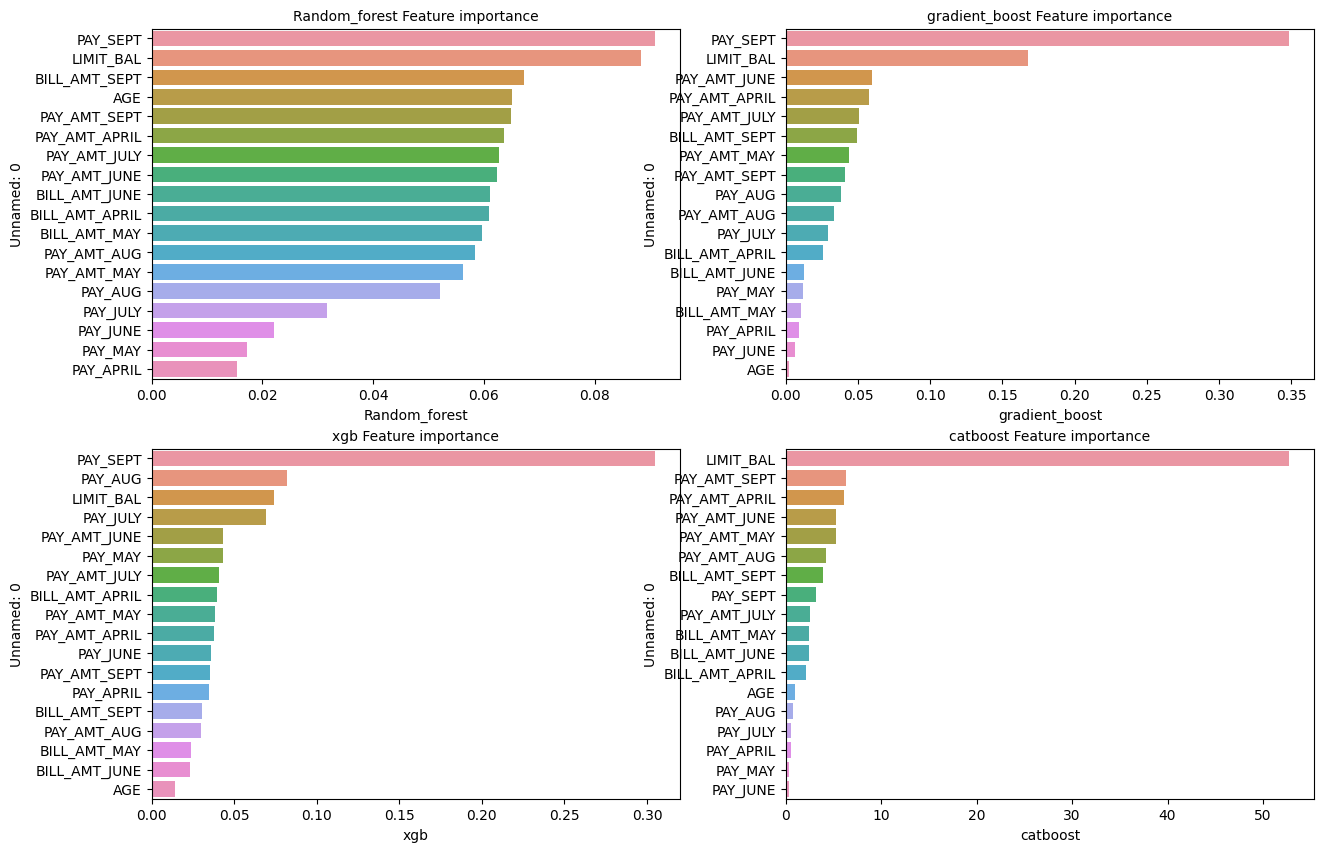

In [ ]:
#Define size of bar plot
fig, axes = plt.subplots(2,2,figsize=(15,10))
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

row = -1
for i, column in enumerate(['Random_forest','gradient_boost','xgb','catboost']):
    #Sort the DataFrame in order decreasing feature importance
    random = features_impo.sort_values(by=[column], ascending=False)

    col = i%2
    if col==0:row+=1
    #Plot Searborn bar chart
    chart = sns.barplot(x=random[column], y=random['Unnamed: 0'],ax=axes[row][col])
    chart.set_title(column+' Feature importance', fontdict={'size': 10})

`PAY_SEPT and LIMIT_BAL` has high importance among 4 models. So we will use `SequentialFeatureSelector from sklearn` to select the important features which gives same result as above.

In [ ]:
%%time
from sklearn.feature_selection import SequentialFeatureSelector

n_features = list(X_train.columns)

catboost = XGBClassifier(n_estimators=150,
                         max_depth=6,
                         learning_rate=0.05)

sfs = SequentialFeatureSelector(estimator = catboost,
                                n_features_to_select='auto',
                                scoring = 'roc_auc')
sfs.fit(X_train,y_train)

list_select = list(sfs.get_support())

list_columns = list(X_train.columns)
list_features = [list_columns[i] for i,value in enumerate(list_select) if value]

print(list_features)

['LIMIT_BAL', 'PAY_SEPT', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'PAY_AMT_SEPT', 'PAY_AMT_JULY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY', 'PAY_AMT_APRIL']
CPU times: user 10min 12s, sys: 3.59 s, total: 10min 16s
Wall time: 6min 7s


So we will train the stacking classifier using these selected features with different combination will check which combination gives best result.

In [ ]:
X_train_selected = X_train.loc[:,list_features]
X_test_selected = X_test.loc[:,list_features]

X_train_selected.columns

Index(['LIMIT_BAL', 'PAY_SEPT', 'BILL_AMT_MAY', 'BILL_AMT_APRIL',
       'PAY_AMT_SEPT', 'PAY_AMT_JULY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL'],
      dtype='object')

In [ ]:
%%time
stacking_results =  get_results_stacking_classifier(X_train_selected, y_train,
                                                    X_test_selected,y_test)
stacking_results

CPU times: user 12min 15s, sys: 3.02 s, total: 12min 18s
Wall time: 11min 39s


,base_estimators,final_estimators,train_accuracy,test_accuracy,roc_score
0,"[(catboost, <catboost.core.CatBoostClassifier ...","XGBClassifier(base_score=None, booster=None, c...",0.896822,0.871496,0.871602
1,"[(catboost, <catboost.core.CatBoostClassifier ...","GradientBoostingClassifier(learning_rate=0.05,...",0.896929,0.872459,0.872563
2,"[(gb, GradientBoostingClassifier(learning_rate...",<catboost.core.CatBoostClassifier object at 0x...,0.907255,0.867751,0.867845


As we can see the result that result using `nine features` gives same result as using `17 features. `we will use these 9 features and stacking with combination of `catboost and gradient boost for base_estimators and final_estimators will be XGBoost`..

In [ ]:


# Create a XGBoost classifier
xgbboost = XGBClassifier(n_estimators=150,
                          max_depth=6,
                          learning_rate=0.05)

# Create a gradient boosting classifier
gradientboost = GradientBoostingClassifier(n_estimators=150,
                                            max_depth=6,
                                            learning_rate=0.05)

# Create a catboost
catboost = CatBoostClassifier(verbose=False,
                              n_estimators=160,
                              max_depth=7,
                              allow_writing_files=False)


sclf = StackingClassifier(estimators=[('catboost',catboost),
                                      ('gb', gradientboost)],
                          final_estimator=xgbboost,
                          cv=10,passthrough = True)
sclf.fit(X_train_selected, y_train)

print("model score is {}".format(sclf.score(X_test_selected,y_test)))

filepath = ".//dataFiles//stacking_final_model.pkl"

with open(filepath, "wb") as file_pointer:
    pickle.dump(sclf, file_pointer)

model score is 0.871495827091804


In [ ]:
X_test_selected.head()

,LIMIT_BAL,PAY_SEPT,BILL_AMT_MAY,BILL_AMT_APRIL,PAY_AMT_SEPT,PAY_AMT_JULY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL
5466,0.137255,2,0.493133,0.481400,0.000999,0.000000,0.107784,0.154845,0.203932
32546,0.039216,2,0.482216,0.479947,0.138135,0.161496,0.117475,0.179727,0.123164
19306,0.274510,0,0.492313,0.488339,0.157541,0.166495,0.124791,0.127113,0.126108
39400,0.243470,0,0.574671,0.576568,0.528719,0.197644,0.215207,0.304980,0.416589
22996,0.960784,-2,0.345165,0.334658,0.234632,0.329617,0.230384,0.262887,0.606397


In [ ]:
y_test

5466     1
32546    1
19306    0
39400    1
22996    0
        ..
17735    1
43773    1
15219    0
5183     0
14712    0
Name: default.payment.next.month, Length: 9346, dtype: int64